# Linear Regression
Linear regression is a good starting point for regression tasks. Such models are popular because they can be fit very quickly and are very interpretable.
<br>
In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Simple linear regression
We will start with the most familiar linear regression, a straight-line fit to data. A straight-line fit is a model of the form<br><br>

<b>y = ax + b</b>

<br>
where <b>a</b> is commonly known as the <b>slope</b>, and <b>b</b> is commonly known as the <b>intercept</b>.<br><br>

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

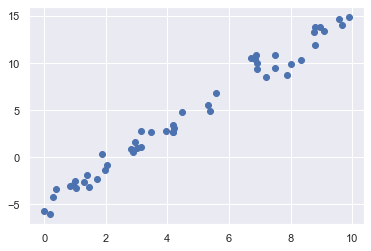

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y)

We can use Scikit-Learn's LinearRegression estimator to fit this data and construct the best-fit line:

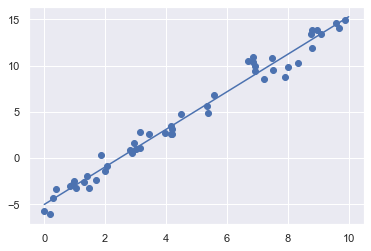

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y) #fitting a model requires feature matrix which is x, and target which is y. x needs to be multidimensional therefore we use np.newaxis

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore. Here the relevant parameters are <b>coef_</b> and <b>intercept_</b>:

In [4]:
print("Model slope: ", model.coef_)
print("Model intercept: ", model.intercept_)

Model slope:  [2.02720881]
Model intercept:  -4.998577085553204


We see that the results are very close to the inputs.

The LinearRegression estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle <b>multidimensional linear models</b> of the form<br>

<b>$y = a_0 + a_1x_1 + a_2x_2 + ...$</b>
<br><br>
Geometrically, this is akin to <u>fitting a plane to points in three dimensions</u>, or fitting a <b>hyper-plane</b> to points in <b>higher dimensions</b>.
<br>
The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.50000000000001
[ 1.5 -2.   1. ]


Here the <b>$y$ data</b> is constructed from <b>three random $x$ values</b>, and the linear regression recovers the coefficients used to construct the data.

# Basis Function Regression
One trick you can use to adapt linear regression to <b>nonlinear relationships</b> between variables is to transform the data according to <b>basis functions</b>. We have seen one version of this before, in the <b>PolynomialRegression pipeline</b> used in <u>Hyperparameters and Model Validation and Feature Engineering</u>. The idea is to take our multidimensional linear model:
<br>
<b>$y = a_0 + a_1x_1 + a_2x_2 + ...$</b>
<br><br>

and build the $x_1$, $x_2$, $x_3$, and so on, from our single-dimensional input $x$. That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.<br>
For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:<br>

<b>$y = a_0 + a_1x^1 + a_2x^2 + ...$</b>
<br><br>
Notice that this is still a linear model—the <u>linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other</u>. What we have effectively done is taken our one-dimensional $x$ values and projected them into a <u>higher dimension</u>, so that a linear fit can fit more complicated relationships between $x$ and $y$.

## Polynomial basis functions
This polynomial projection is useful enough that it is built into Scikit-Learn, using the <b>PolynomialFeatures</b> transformer:

In [6]:
from sklearn.preprocessing import PolynomialFeatures

x = np.array([2,3,4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

#the output will be like x,y,z - x^2,y^2,z^2 - x^3,y^3,z^3 depending on the input degree given to PolynomialFeatures

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our <b>one-dimensional array</b> into a <b>three-dimensional array</b> by taking the <b>exponent</b> of each value. This new, higher-dimensional data representation can then be plugged into a linear regression.<br><br>

As we saw in Feature Engineering, the cleanest way to accomplish this is to use a pipeline. Let's make a 7th-degree polynomial model in this way:

In [7]:
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())


With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$. For example, here is a sine wave with noise:

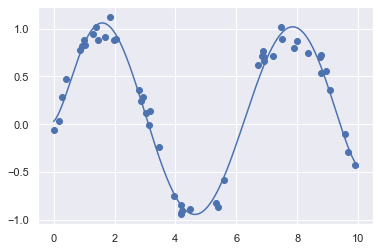

In [8]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data!
## Gaussian basis functions
Other basis functions are possible. For example, one useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases. The result might look something like the following figure:

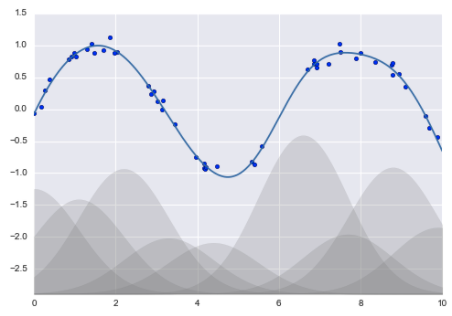

The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data. These Gaussian basis functions are not built into Scikit-Learn, but we can write a custom transformer that will create them, as shown here and illustrated in the following figure (Scikit-Learn transformers are implemented as Python classes; reading Scikit-Learn's source is a good way to see how they can be created):

(0.0, 10.0)

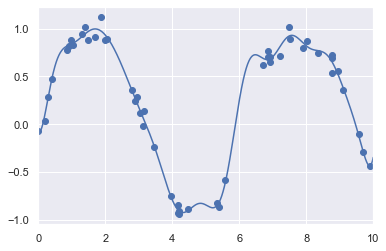

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    def __init__ (self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
        
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x-y)/width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20), LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10)

We put this example here just to make clear that there is nothing magic about polynomial basis functions: if you have some sort of intuition into the generating process of your data that makes you think one basis or another might be appropriate, you can use them as well.

# Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly <b>lead to over-fitting</b> (refer back to <u>Hyperparameters and Model Validation</u> for a discussion of this). For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

(-1.5, 1.5)

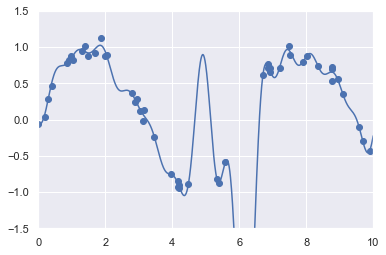

In [10]:
model = make_pipeline(GaussianFeatures(30), LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)

With the data projected to the <b>30-dimensional basis</b>, the model has far <b>too much flexibility</b> and goes to extreme values between locations where it is constrained by data. We can see the reason for this if we plot the <u>coefficients of the Gaussian bases</u> with respect to their locations:

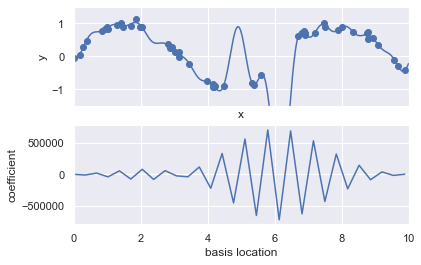

In [11]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
        
    ax[1].plot(model.steps[0][1].centers_,
              model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
             ylabel='coefficient',
             xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

The <b>lower panel</b> of this figure shows the <b>amplitude</b> of the basis function at each location. This is typical <b>over-fitting behavior</b> when basis functions overlap: the <u>coefficients of adjacent basis functions blow up and cancel each other out</u>. We know that such behavior is problematic, and it would be nice if we could limit such spikes expliticly in the model by penalizing large values of the model parameters. Such a penalty is known as <b>regularization</b>, and comes in several forms.

## Ridge regression ($L_2$ Regularization)
Perhaps the most common form of regularization is known as ridge regression or $L_2$ regularization, sometimes also called Tikhonov regularization. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be
<br><br>

P = $\alpha$ $\sum \limits _{n-1} ^{n} \theta _{n} ^{2}$

<br>
where $\alpha$ is a free parameter that controls the strength of the penalty. This type of penalized model is built into Scikit-Learn with the Ridge estimator.<br><br>

<b>Ridge regression</b> is a <u>model tuning method</u> that is used to analyse any <u>data that suffers from multicollinearity</u>. This method performs <b>L2 regularization</b>. When the issue of <u>multicollinearity</u> occurs, <u>least-squares are unbiased</u>, and <u>variances are large</u>, this results in predicted values to be far away from the actual values.

<br>
By changing the values of $\alpha$, we are <u>controlling the penalty term</u>. <u>Higher</u> the values of $\alpha$, <u>bigger is the penalty</u> and therefore the <u>magnitude of coefficients is reduced</u>.
<br>

1. It shrinks the parameters. Therefore, it is used to prevent multicollinearity.
2. It reduces the model complexity by coefficient shrinkage.

<br>

### Bias and variance trade-off

Bias and variance trade-off is generally complicated when it comes to building ridge regression models on an actual dataset. However, following the general trend which one needs to remember is:
1. The bias increases as $\alpha$ increases.
2. The variance decreases as $\alpha$ increases.


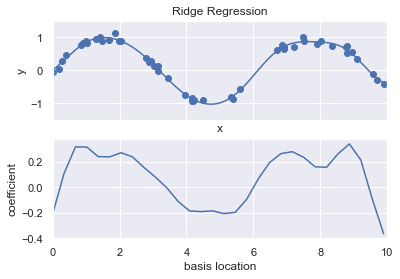

In [18]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

## Lasso Regression ($L_1$ regularization)
Another very common type of regularization is known as lasso and involved penalizing the sum of absolute values (1-norms) of regression coefficients. 
<br>

Lasso regression is a type of <b>linear regression</b> that uses <b>shrinkage</b>. Shrinkage is where <u>data values are shrunk towards a central point</u>, like the <u>mean</u>. The lasso procedure encourages <u>simple, sparse models</u> (i.e. models with <u>fewer parameters</u>). This particular type of regression is <u>well-suited for models</u> showing <u>high</u> levels of <b>muticollinearity</b> or when you want to automate certain parts of model selection, like variable selection/parameter elimination.<br>

Lasso regression performs <b>L1 regularization</b>, which adds a <u>penalty</u> equal to the <u>absolute value of the magnitude of coefficients</u>. This type of regularization can <u>result in sparse models with few coefficients</u>; Some <u>coefficients</u> can become <b>zero</b> and <b>eliminated</b> from the model. <u>Larger penalties</u> result in <u>coefficient values closer to zero</u>, which is the ideal for producing <u>simpler models</u>. On the other hand, L2 regularization (e.g. Ridge regression) doesn’t result in elimination of coefficients or sparse models. This makes the Lasso far easier to interpret than the Ridge.

<br>

$P = \alpha \sum \limits _{n-1} ^{n}  |\theta _{n}| $

<br>
Though this is conceptually very similar to ridge regression, the results can differ suprisingly: for example, due to the geometric reasons lasso regression tends to favour sparse models where possible; that is, it preferentially sets model coefficients to exactly 0.<br>
We can see this behaviour in duplicating the ridge regression, but using the L1-normalized coefficients.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002135815870489055, tolerance: 0.002065280097246271
  model = cd_fast.enet_coordinate_descent(


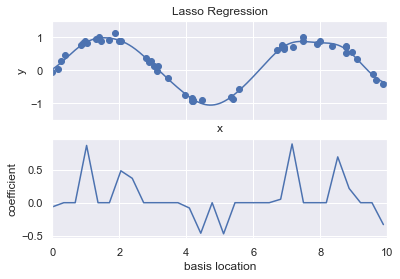

In [22]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

With the lasso regression penalty, the majority of the coefficients are exactly 0, with the functional behaviour being modeled by a small subset of the available basis functions. As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty and should be determined via, for example cross-validation.

# Example: Predicting Bicycle Traffic
As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.<br>
